# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [6]:
import os
import time
import uuid
import cv2

In [5]:
image_path=os.path.join('data', 'images')
image_number=30

In [9]:
cap=cv2.VideoCapture(0)
for imgnum in range(image_number):
    print(f'Collecting image {imgnum}')
    ret, frame= cap.read()
    imgname= os.path.join(image_path, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    

### 1.3 Annotate Images with LabelMe

In [15]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF 

In [5]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

### 2.2 Load Image into TF data pipeline

In [15]:
images=tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [16]:
images.as_numpy_iterator().next()

b'data\\images\\2e27874a-2b08-11ee-9695-709cd173284a.jpg'

In [4]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [18]:
images=images.map(load_image)

In [19]:
images.as_numpy_iterator().next()

array([[[132, 110,  86],
        [137, 115,  91],
        [142, 122,  98],
        ...,
        [ 59,  68,  49],
        [ 58,  69,  55],
        [ 59,  69,  58]],

       [[137, 115,  92],
        [141, 121,  97],
        [139, 119,  95],
        ...,
        [ 75,  84,  67],
        [ 69,  80,  66],
        [ 60,  70,  61]],

       [[139, 118,  97],
        [140, 119,  98],
        [139, 118,  97],
        ...,
        [ 98, 106,  91],
        [ 94, 104,  95],
        [ 85,  95,  87]],

       ...,

       [[ 86,  79,  63],
        [ 85,  78,  62],
        [ 85,  77,  64],
        ...,
        [173, 175, 196],
        [176, 174, 196],
        [170, 168, 190]],

       [[ 84,  74,  62],
        [ 84,  74,  62],
        [ 85,  77,  64],
        ...,
        [180, 178, 199],
        [180, 175, 197],
        [173, 168, 190]],

       [[ 86,  76,  64],
        [ 87,  77,  65],
        [ 88,  80,  67],
        ...,
        [179, 176, 195],
        [182, 174, 195],
        [178, 170, 191]]

In [20]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [21]:
image_generator = images.batch(4).as_numpy_iterator().next()

In [ ]:
fig, ax= plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(image_generator):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

### 3.1 Manually split data into train test and validation

In [24]:
90*.7 # take 63 to train

62.99999999999999

In [26]:
90*.15 # 14 and 13 to test and val

13.5

In [29]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

# 4. Apply Image Augmentation on Imges ans Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipiline

In [2]:
import albumentations as alb

In [3]:
augmentor= alb.Compose([alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

### 4.2 Load a test image and annotation with OpenCV and JSON

In [6]:
img= cv2.imread(os.path.join('data','train','images','2ec93229-2b08-11ee-8a95-709cd173284a.jpg'))

In [10]:
with open(os.path.join('data','train','labels','2ec93229-2b08-11ee-8a95-709cd173284a.json'),'r') as f:
    label=json.load(f)

In [16]:
label['shapes'][0]['points']

[[270.0, 115.53191489361706], [405.1063829787234, 290.00000000000006]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [32]:
coords=[0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [33]:
coords

[270.0, 115.53191489361706, 405.1063829787234, 290.00000000000006]

In [34]:
coords=list(np.divide(coords, [640, 480, 640, 480]))

In [35]:
coords

[0.421875, 0.2406914893617022, 0.6329787234042553, 0.6041666666666667]

In [36]:
type(coords)

list

### 4.4 Apply Augmentations and View Results

In [37]:
augmented= augmentor(image= img, bboxes=[coords], class_labels=['face'])

In [46]:
augmented['bboxes']

[(0.4022222222222222,
  0.4177777777777777,
  0.7024586288416075,
  0.8054846335697399)]

In [45]:
augmented['bboxes'][0][:2]

(0.4022222222222222, 0.4177777777777777)

In [ ]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB))

# 5. Build and Run Augmentation Pipiline

### 5.1 Run Augmentation Pipeline

In [49]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [5]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [55]:
train_images.as_numpy_iterator().next()

array([[[0.44074756, 0.40643382, 0.36476716],
        [0.43382353, 0.39460784, 0.35557598],
        [0.41121325, 0.37573528, 0.34044117],
        ...,
        [0.6254902 , 0.6478554 , 0.71501225],
        [0.6357843 , 0.6617647 , 0.7245098 ],
        [0.5871936 , 0.6161765 , 0.6862745 ]],

       [[0.4362745 , 0.3851103 , 0.34981617],
        [0.4259804 , 0.37414217, 0.34019607],
        [0.3923407 , 0.3516544 , 0.31685048],
        ...,
        [0.5808211 , 0.58566177, 0.6533701 ],
        [0.6023897 , 0.6140931 , 0.67058825],
        [0.57273287, 0.59142154, 0.6466299 ]],

       [[0.42892158, 0.3740196 , 0.33382353],
        [0.4122549 , 0.35441175, 0.32647058],
        [0.38204658, 0.3310662 , 0.30753675],
        ...,
        [0.63688725, 0.64865196, 0.72205883],
        [0.639951  , 0.64577204, 0.71427697],
        [0.6052696 , 0.60833335, 0.66813725]],

       ...,

       [[0.47107843, 0.40441176, 0.33382353],
        [0.453799  , 0.38713235, 0.31654412],
        [0.47487745, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
              label=json.load(f)
    return [label['class'], label['bbox']]

### 6.2 Load labels to tensorflow Dataset

In [9]:
train_labels= tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels= train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels= tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels= test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels=tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels= val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))

# 7. Combine Label and Image Samples

### 7.1 Check Partition lengths

In [12]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### 7.2 Create Final Dataset

In [12]:
train= tf.data.Dataset.zip((train_images, train_labels))
train= train.shuffle(5000)
train= train.batch(8)
train= train.prefetch(4)

In [13]:
test= tf.data.Dataset.zip((test_images, test_labels))
test= test.shuffle(1300)
test= test.batch(8)
test= test.prefetch(4)

In [14]:
val= tf.data.Dataset.zip((val_images,val_labels))
val=val.shuffle(1000)
val= val.batch(8)
val= val.prefetch(4)

In [16]:
train.as_numpy_iterator().next()[1]

(array([1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8),
 array([[0.5425 , 0.3894 , 0.759  , 0.6353 ],
        [0.5957 , 0.3164 , 0.805  , 0.576  ],
        [0.1605 , 0.1589 , 0.612  , 0.6753 ],
        [0.2122 , 0.3513 , 0.621  , 0.8594 ],
        [0.2299 , 0.26   , 0.573  , 0.7505 ],
        [0.4226 , 0.2883 , 0.687  , 0.595  ],
        [0.3118 , 0.3694 , 0.521  , 0.643  ],
        [0.08716, 0.1768 , 0.5386 , 0.693  ]], dtype=float16))

### 7.3 View Images and Annotations

In [17]:
sample= train.as_numpy_iterator().next()

In [ ]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image= sample[0][idx]
    sample_coords= sample[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)
    

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [21]:
vgg=VGG16(include_top=False)

58889256/58889256 [==============================] - 24s 0us/step


### 8.3 Build instance of Network

In [18]:
input_layer= Input(shape=(120,120,3))

vgg= VGG16(include_top=False)(input_layer)

#classification model
f1=GlobalMaxPooling2D()(vgg)
class1=Dense(2048, activation='relu')(f1)
class2=Dense(1, activation='sigmoid')(class1)

#bounding box model
f2=GlobalMaxPooling2D()(vgg)
regress1= Dense(2048, activation='relu')(f2)
regress2= Dense(4, activation='sigmoid')(regress1)

facetracker= Model(inputs=input_layer, outputs=[class2, regress2])
    

### 8.4 Test out Neural Network

In [19]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [20]:
X,y = train.as_numpy_iterator().next()

In [25]:
X.shape

(8, 120, 120, 3)

In [29]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 661ms/step


In [27]:
classes, coords

(array([[0.5480733 ],
        [0.5392124 ],
        [0.5009143 ],
        [0.34176552],
        [0.43130228],
        [0.4937439 ],
        [0.47528896],
        [0.4024656 ]], dtype=float32),
 array([[0.4661697 , 0.33928317, 0.28652444, 0.39145097],
        [0.54680586, 0.4284598 , 0.3142931 , 0.35179463],
        [0.5397019 , 0.39248347, 0.3215008 , 0.3751637 ],
        [0.51352537, 0.3584249 , 0.2764452 , 0.34419328],
        [0.579845  , 0.34466922, 0.23656812, 0.31823054],
        [0.4950072 , 0.34326142, 0.2953518 , 0.32127547],
        [0.5721763 , 0.32135835, 0.27683032, 0.36255044],
        [0.48294595, 0.40363136, 0.30599508, 0.37711176]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and Learning Rate

In [22]:
batches_per_epoch = len(train)
lr_decay = (1/0.75 -1)/batches_per_epoch

In [24]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [25]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true= y_true[:,3] - y_true[:,1]
    w_true=y_true[:,2] - y_true[:,0]
    
    h_pred= yhat[:,3] - yhat[:,1]
    w_pred= yhat[:,2] - yhat[:,0]
    
    delta_size= tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [33]:
classloss= tf.keras.losses.BinaryCrossentropy()
regressloss= localization_loss

### 9.3 Test out Loss Metrics

In [30]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9558206>

In [31]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.47007495>

In [34]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9558206>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [35]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [36]:
model = FaceTracker(facetracker)

In [37]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [38]:
logdir='logs'

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [41]:
hist= model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 761s 2s/step - total_loss: 0.0224 - class_loss: 1.6726e-04 - regress_loss: 0.0223 - val_total_loss: 0.0157 - val_class_loss: 8.3422e-05 - val_regress_loss: 0.0157
Epoch 2/10
473/473 [==============================] - 768s 2s/step - total_loss: 0.0069 - class_loss: 1.5640e-05 - regress_loss: 0.0069 - val_total_loss: 0.0121 - val_class_loss: 1.0878e-05 - val_regress_loss: 0.0121
Epoch 3/10
473/473 [==============================] - 779s 2s/step - total_loss: 0.0043 - class_loss: 5.0220e-06 - regress_loss: 0.0043 - val_total_loss: 0.0229 - val_class_loss: 1.1772e-06 - val_regress_loss: 0.0229
Epoch 4/10
473/473 [==============================] - 785s 2s/step - total_loss: 0.0030 - class_loss: 2.4659e-06 - regress_loss: 0.0030 - val_total_loss: 0.0053 - val_class_loss: 2.5779e-06 - val_regress_loss: 0.0053
Epoch 5/10
473/473 [==============================] - 785s 2s/step - total_loss: 0.0023 - class_loss: 1.2958e-06 - regress_loss: 0.0

### 10.3 Plot Performance

In [42]:
hist.history

{'total_loss': [0.001630502287298441,
  0.0019102676305919886,
  0.004191925283521414,
  0.0007239021360874176,
  0.0018250977154821157,
  0.0007865295046940446,
  0.0009451098740100861,
  0.00039690244011580944,
  0.00028221943648532033,
  0.000865885813254863],
 'class_loss': [2.561565997893922e-05,
  5.692286322300788e-06,
  5.453855010273401e-06,
  3.2037585242505884e-06,
  7.00354917171353e-07,
  2.9802333756379085e-07,
  2.980232594040899e-08,
  1.0430814256778831e-07,
  5.364422577258665e-07,
  1.4901162970204496e-08],
 'regress_loss': [0.0016176945064216852,
  0.0019074215088039637,
  0.00418919837102294,
  0.000722300261259079,
  0.0018247475381940603,
  0.0007863804930821061,
  0.0009450949728488922,
  0.000396850286051631,
  0.00028195121558383107,
  0.0008658783626742661],
 'val_total_loss': [0.015746526420116425,
  0.012061597779393196,
  0.022902853786945343,
  0.005348485894501209,
  0.004623983055353165,
  0.0072167059406638145,
  0.003911325708031654,
  0.0059091169387

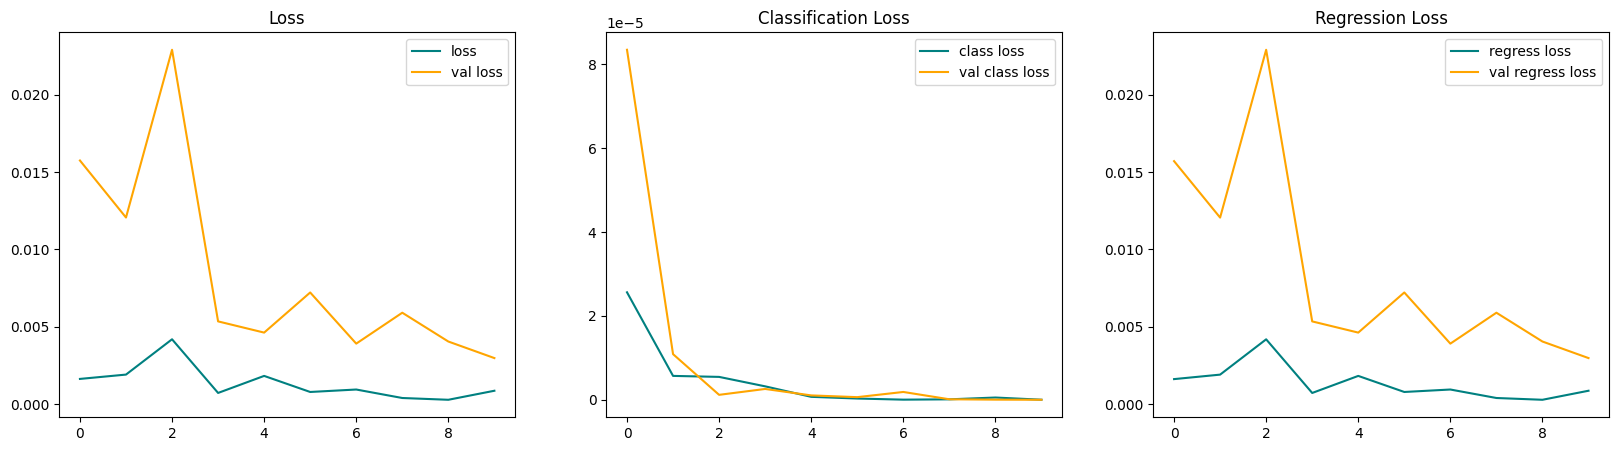

In [43]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [44]:
test_data = test.as_numpy_iterator()

In [45]:
test_sample = test_data.next()

In [46]:
test_sample

(array([[[[0.5082108 , 0.41360295, 0.44154412],
          [0.5396446 , 0.4305147 , 0.48768383],
          [0.47003677, 0.38210785, 0.42708334],
          ...,
          [0.34987745, 0.27224264, 0.18713236],
          [0.3310662 , 0.26292893, 0.16390932],
          [0.29577205, 0.24883579, 0.14626226]],
 
         [[0.49289215, 0.41911766, 0.42971814],
          [0.4190564 , 0.3621936 , 0.38903186],
          [0.5092524 , 0.4141544 , 0.43713236],
          ...,
          [0.3452206 , 0.2829657 , 0.1927696 ],
          [0.32003677, 0.26127452, 0.16960785],
          [0.29822305, 0.25116423, 0.15643382]],
 
         [[0.50104165, 0.41513482, 0.4471201 ],
          [0.41072303, 0.36158088, 0.39411765],
          [0.4038603 , 0.33045343, 0.3469363 ],
          ...,
          [0.31832108, 0.2747549 , 0.16580883],
          [0.31642157, 0.27328432, 0.16348039],
          [0.31311274, 0.26115197, 0.15704657]],
 
         ...,
 
         [[0.26593137, 0.30300245, 0.30036765],
          [0.29283

In [47]:
yhat= facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 435ms/step


In [49]:
yhat

[array([[0.9999993 ],
        [0.9999999 ],
        [1.        ],
        [0.9999998 ],
        [0.9999998 ],
        [0.9999999 ],
        [1.        ],
        [0.99999994]], dtype=float32),
 array([[0.5752253 , 0.40005177, 0.78437096, 0.68882084],
        [0.14899361, 0.29673153, 0.41806045, 0.6598062 ],
        [0.1947463 , 0.2458918 , 0.6371652 , 0.8615697 ],
        [0.21148175, 0.2900904 , 0.5475103 , 0.71311456],
        [0.36512008, 0.30882177, 0.7044811 , 0.72840565],
        [0.1941349 , 0.25085038, 0.52593726, 0.6645717 ],
        [0.3480694 , 0.17416446, 0.79476774, 0.8014584 ],
        [0.22458383, 0.26741084, 0.56381226, 0.704079  ]], dtype=float32)]

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [1]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()